# Virtrual Screening for Active Noninsulin Glucose-lowering Drugs

In [ ]:
import logging

from collections import Counter
from operator import itemgetter
from lxml import etree

# from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools, Lipinski
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover

from IPython.display import Image, display
import pandas as pd
import json

import sys
sys.path.append('~/Desktop/JOB/BrightSeed')
from log_progress import *

In [2]:
from chembl_webresource_client.settings import Settings
from chembl_webresource_client.new_client import new_client

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import pubchempy as pcp
from IPython.display import HTML
size = (150, 150)  # Smaller figures than the default.

In [4]:
def unsalt(smiles):
    remover = SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    mol = remover.StripMol(mol)
    return Chem.MolToSmiles(mol, True)

def lipinski_ro5_vio(alogp, hba, hbd, mw):
    tmp = np.array([0]*4)
    return(len(tmp[[hbd>5, hba>10, mw>500, alogp>5]]))

In [5]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)
print(len(available_resources))

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'document_term', 'drug', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_prediction', 'target_relation', 'tissue', 'xref_source']
35


In [6]:
# Get a molecule-handler object for API access and check the connection to the database...
molecule = new_client.molecule
molecule.set_format('json')
print("%s molecules available in myChEMBL_20" % len(molecule.all()))

1879206 molecules available in myChEMBL_20


# Import approved drugs, public, and in-house compounds

## Data Preparation

#### 12 Approved Type 2 Diabetes Mellitus Drugs

In [496]:
# Build a table of approved drugs
Drugs=[['Metformin','CHEMBL1431'],['Dapagliflozin','CHEMBL429910'],['Empagliflozin','CHEMBL2107830'],
      ['Alogliptin','CHEMBL376359'],['Linagliptin','CHEMBL237500'],['Sitagliptin','CHEMBL1422'],
      ['Saxagliptin','CHEMBL1201743'],['Glimepiride','CHEMBL1481'],['Glipizide','CHEMBL1073'],
      ['Glyburide','CHEMBL472'],['Pioglitazone','CHEMBL595'],['Rosiglitazone','CHEMBL121']]
Drugs=np.array(Drugs)

# obtain canonical smiles
smiles = list(map(lambda i: molecule.get(Drugs[i,1])['molecule_structures']['canonical_smiles'], range(len(Drugs))))
# remove salts and solvates
smiles = list(map(lambda i: unsalt(i), smiles))

columns=['product_name', 'chembl_id','SMILES']
Drugs = pd.DataFrame(np.concatenate([Drugs, np.array(smiles).reshape(-1,1)],axis=1), columns=columns)

,product_name,chembl_id,ROMol,SMILES
0,Metformin,CHEMBL1431,,CN(C)C(=N)NC(=N)N
1,Dapagliflozin,CHEMBL429910,,CCOc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)ccc2Cl)cc1
2,Empagliflozin,CHEMBL2107830,,OC[C@H]1O[C@@H](c2ccc(Cl)c(Cc3ccc(O[C@H]4CCOC4)cc3)c2)[C@H](O)[C@@H](O)[C@@H]1O
3,Alogliptin,CHEMBL376359,,Cn1c(=O)cc(N2CCC[C@@H](N)C2)n(Cc2ccccc2C#N)c1=O
4,Linagliptin,CHEMBL237500,,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C
5,Sitagliptin,CHEMBL1422,,N[C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1cc(F)c(F)cc1F
6,Saxagliptin,CHEMBL1201743,,N#C[C@@H]1C[C@@H]2C[C@@H]2N1C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2
7,Glimepiride,CHEMBL1481,,CCC1=C(C)CN(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)N[C@H]3CC[C@H](C)CC3)cc2)C1=O
8,Glipizide,CHEMBL1073,,Cc1cnc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)cc2)cn1
9,Glyburide,CHEMBL472,,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1

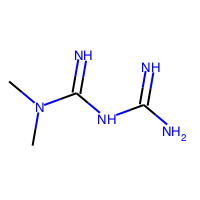
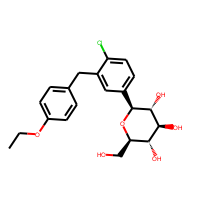
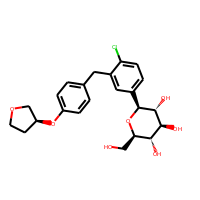
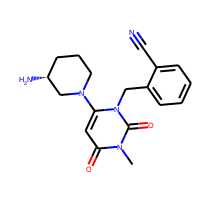
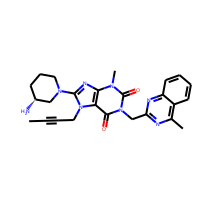
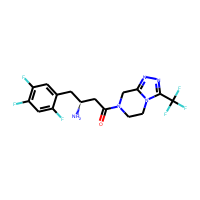
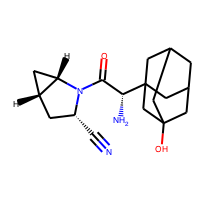
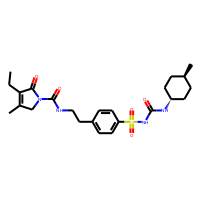
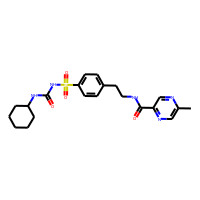
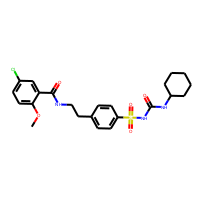
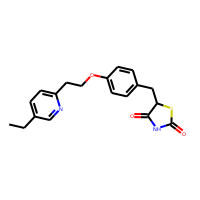
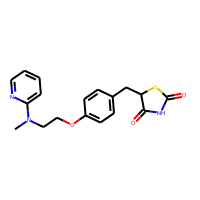

In [681]:
PandasTools.AddMoleculeColumnToFrame(Drugs, smilesCol = 'SMILES',includeFingerprints=True)
Drugs[['product_name', 'chembl_id','ROMol','SMILES']]

#### 1000 in-house compounds

In [832]:
# import a list of smiles strings
data = pd.read_csv('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/example_compound_library.csv')

# Split compounds with multiple smiles
print(data[23:24])

data_ary=np.array(data)
data2_ary=[]
for i in range(len(data_ary)):
    isolist = data_ary[i,1].split('|')
    num_iso = len(isolist)
    for j,iso in enumerate(isolist):
        data2_ary.append([data_ary[i,0], j, iso])
        
data2 = pd.DataFrame(data2_ary, columns=[data.columns[0],'isomer_id',data.columns[1]])

# remove slats and solvates
smiles = list(map(lambda i: unsalt(i), data2['SMILES']))
data2['SMILES']=smiles

    compound_id                                                                   SMILES
23           24  CC1=C(O)C=C2C(=C1)C=C(C(C)C)C=C2CO | CC1=CC2=C(C=C1O)C(CO)=CC(C(C)C)=C2


- Remove duplicate canonical smiles

In [833]:
# convert smiles to conical smiles
CSMILE=[]
for i in range(len(data2)):
    m=Chem.MolFromSmiles(data2['SMILES'].iloc[i])
    csmile=Chem.MolToSmiles(m, True)
    CSMILE.append(csmile)
    
iso_index = list(data2[data2['isomer_id']==1].index)
for _,i in enumerate(iso_index):
    if (CSMILE[i]==CSMILE[i-1])==False:
        print(i, CSMILE[i]==CSMILE[i-1])
iso_index = list(data2[data2['isomer_id']==2].index)
for _,i in enumerate(iso_index):
    if (CSMILE[i]==CSMILE[i-1])==False:
        print(i, CSMILE[i]==CSMILE[i-1])
        
data2 = data2[data2['isomer_id']==0].reset_index()
data2 = data2[['compound_id','SMILES']]
data2.shape

(1000, 2)

,compound_id,SMILES,ROMol
160,161,CC(O)(CC(=O)O)CC(=O)OCc1ccc(OC2OC(CO)C(O)C(O)C2O)cc1,
161,162,CC(O)(CC(=O)O)CC(=O)OCc1ccc(O[C@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)cc1,

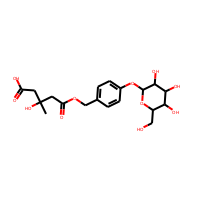
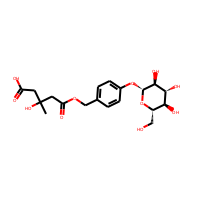

In [835]:
PandasTools.AddMoleculeColumnToFrame(data2, smilesCol = 'SMILES',includeFingerprints=True)
# data2[['compound_id', 'ROMol','SMILES']].head()
data2[160:162]

In [836]:
# size=(150,150)
# m = Chem.MolFromSmiles(data2['SMILES'].iloc[160])
# figure = Draw.MolToMPL(m,size=size)

# m = Chem.MolFromSmiles(data2['SMILES'].iloc[161])
# figure = Draw.MolToMPL(m,size=size)

#### Generate Morgan Fingerprints for in-house and approved drugs

In [518]:
# fingerprints of approved drugs
fps_drug = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in Drugs['ROMol']]
# fingerprints of in-house data
fps_in_house = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in data2['ROMol']]

#### Remove duplicates with identical 2D fingerprints

In [520]:
fps_in_house_str = list(map(lambda i: fps_in_house[i].ToBitString(), range(len(fps_in_house))))
data3=data2.copy()
data3.insert(2, "fingerprints", fps_in_house_str, True)
data3 = data3.drop_duplicates('fingerprints', keep='first')

778/1000 in-house compounds


,compound_id,ROMol,SMILES
0,1,,COc1cc(OC)c2c(O)c3c(c(-c4c5c(c(O)c6c(OC)cc(O)cc46)CO[C@@H](C)C5O)c2c1)[C@H](O)[C@H](C)OC3
1,2,,CC(C)=CC=C[C@@H](C)[C@]1(C)CC=C2[C@@H]3CC[C@H]4C(C)(C)[C@H](O)CC[C@]4(C)[C@@]3(O)CC[C@]21C
2,3,,COc1cc(OC)c2c(=O)c(O)c(-c3ccc(OC)c(OC)c3)oc2c1
3,4,,C[Se]CC([N+])C(=O)O
4,5,,CC(=O)O[C@H]1[C@@H]2[C@@H](OC(C)=O)[C@]3(OC2(C)C)[C@@](C)(O)CC[C@H](OC(C)=O)[C@@]3(C)[C@H]1O

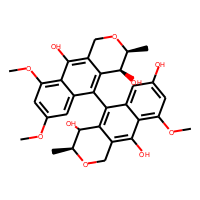
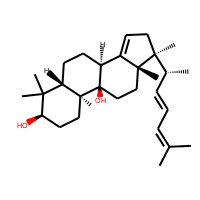
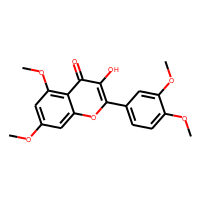
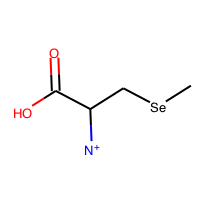
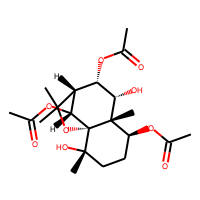

In [548]:
# recalculate fingerprints of experiment data
fps_in_house = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in data2['ROMol']]
len(fps_in_house)
print('==========================')
print('%d/1000 in-house compounds'%len(fps_in_house))
print('==========================')
columns=list(data3.keys())
columns.remove('fingerprints')
data2 = data3[columns]
data2 = data2.reset_index(drop=True)
data2[['compound_id','ROMol','SMILES']].head()

- Only 778 distinct 2D fingerprints among the 1000 in-house compounds 

# Similarity Search (to determine targets)

#### Tanimoto

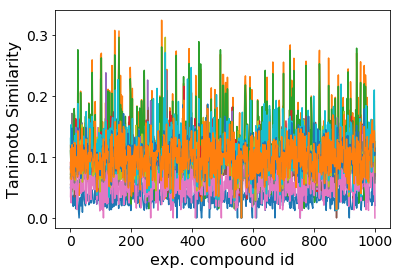

In [527]:
from rdkit import DataStructs

s_Tanimoto = []
for j in range(len(fps_drug)):
    s_ = list(map(lambda i: DataStructs.FingerprintSimilarity(fps_drug[j],fps_in_house[i]), range(len(fps_in_house))))
    s_Tanimoto.append(s_)
s_Tanimoto = np.array(s_Tanimoto)
s_Tanimoto.shape

plt.figure()
for j in range(len(fps_drug)):
    plt.plot(data2['compound_id'], s_Tanimoto[j])
plt.xlabel('exp. compound id', fontsize=16)
plt.ylabel('Tanimoto Similarity', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

- (arrpoved drugs, in-house) pairs with high similairties

In [528]:
best_mol = np.dstack(np.unravel_index(np.argsort(s_Tanimoto.ravel()), s_Tanimoto.shape))
best_mol = np.flipud(best_mol[0])
best_mol[:10]

array([[  1, 233],
       [  1, 116],
       [  1, 127],
       [  8, 240],
       [  2, 127],
       [  2, 333],
       [  1, 565],
       [  1, 333],
       [  2, 233],
       [  2, 734]])

#### Dice

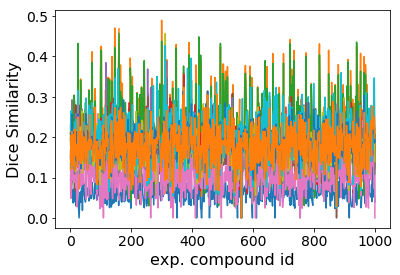

In [529]:
s_Dice = []
for j in range(len(fps_drug)):
    s_ = list(map(lambda i: DataStructs.FingerprintSimilarity(fps_drug[j],fps_in_house[i], metric=DataStructs.DiceSimilarity), range(len(fps_in_house))))
    s_Dice.append(s_)
s_Dice = np.array(s_Dice)

plt.figure()
for j in range(len(fps_drug)):
    plt.plot(data2['compound_id'], s_Dice[j])
plt.xlabel('exp. compound id', fontsize=16)
plt.ylabel('Dice Similarity', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

- (arrpoved drugs, in-house) pairs with high similairties

In [32]:
best_mol = np.dstack(np.unravel_index(np.argsort(s_Dice.ravel()), s_Dice.shape))
best_mol = np.flipud(best_mol[0])
best_mol[:10]

array([[  1, 233],
       [  1, 116],
       [  1, 127],
       [  8, 240],
       [  2, 127],
       [  2, 333],
       [  1, 565],
       [  1, 333],
       [  2, 233],
       [  2, 734]])

#### Top 10 (drug, in-house compound) pairs based on Tanimoto similarity

,rank,similarity,product_name,chembl_id,ROMol_drug,compound_id,ROMol_cmp
0,0,0.324324,Dapagliflozin,CHEMBL429910,,300,
1,1,0.307692,Dapagliflozin,CHEMBL429910,,146,
2,2,0.306667,Dapagliflozin,CHEMBL429910,,160,
3,3,0.296296,Glipizide,CHEMBL1073,,312,
4,4,0.296296,Empagliflozin,CHEMBL2107830,,160,
5,5,0.289157,Empagliflozin,CHEMBL2107830,,422,
6,6,0.283784,Dapagliflozin,CHEMBL429910,,722,
7,7,0.282051,Dapagliflozin,CHEMBL429910,,422,
8,8,0.280488,Empagliflozin,CHEMBL2107830,,300,
9,9,0.278481,Empagliflozin,CHEMBL2107830,,940,

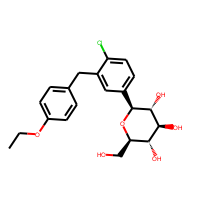
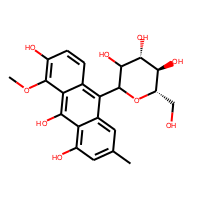
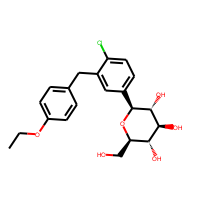
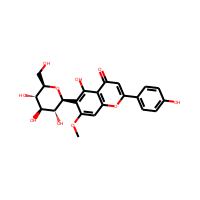
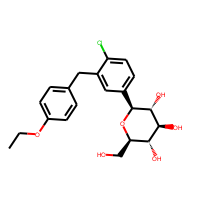
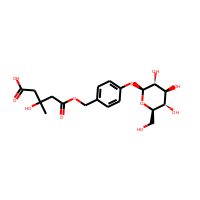
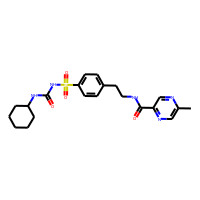
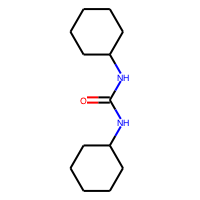
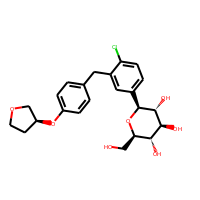
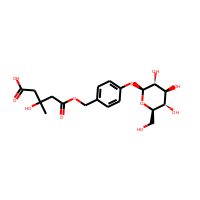
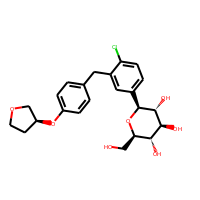
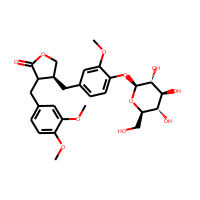
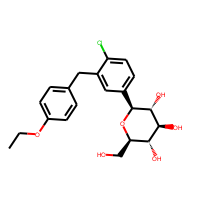
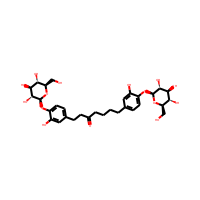
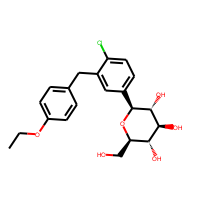
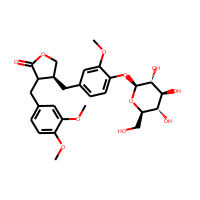
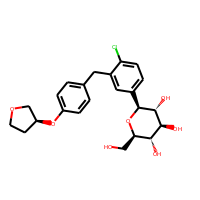
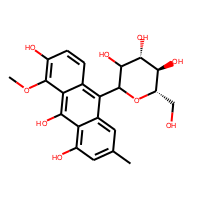
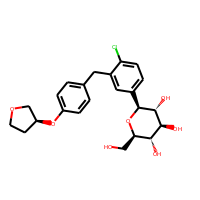
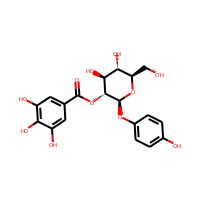

In [530]:
similarity_pairs = []
for i,idx in enumerate(best_mol[:10]):
    drug_ = Drugs.iloc[idx[0]]
    cmp_ = data2.iloc[idx[1]]
    similarity_pairs.append([i, s_Tanimoto[idx[0],idx[1]], drug_['product_name'], drug_['chembl_id'], drug_['ROMol'], 
          cmp_['compound_id'], cmp_['ROMol']])
columns=['rank','similarity','product_name','chembl_id','ROMol_drug','compound_id','ROMol_cmp']
similarity_pairs = pd.DataFrame(similarity_pairs, columns=columns)
similarity_pairs

#### Similarity Maps

/Volumes/750G_Home/anaconda3/envs/my-rdkit-env/lib/python3.5/site-packages/rdkit/Chem/Draw/__init__.py:285: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  Z = mlab.bivariate_normal(X, Y, a, a, mol._atomPs[0][0], mol._atomPs[0][1]) * weights[0]
/Volumes/750G_Home/anaconda3/envs/my-rdkit-env/lib/python3.5/site-packages/rdkit/Chem/Draw/__init__.py:287: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
  Zp = mlab.bivariate_normal(X, Y, a, a, mol._atomPs[i][0], mol._atomPs[i][1])


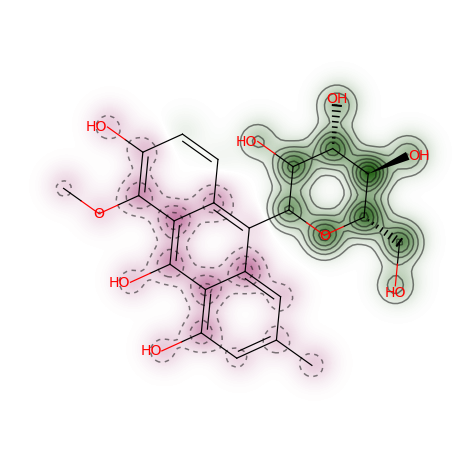

In [537]:
from rdkit.Chem.Draw import SimilarityMaps

mol = Chem.MolFromSmiles(data2['SMILES'].iloc[best_mol[0,1]])
refmol = Chem.MolFromSmiles(Drugs['SMILES'].iloc[best_mol[0,0]])
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, 
                    lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=2, fpType='count'), 
                    metric=DataStructs.TanimotoSimilarity)

# Public data base search
## target: Sodium-dependent glucose co-transporter 2 and similar proteins

- human SGLT1 (accession: P13866)
- human SGLT2 (P31639)
- human SGLT3 (Q9NY91) 
- rat SGLT1 (P53790) 
- mouse SGLT1 (Q9QXI6)
- mouse SGLT2 (Q923I7)

### Fetch activity measurements from ChEMBL

- ChEMBL compounds with K$_i$, IC50, EC50, or K$_d$ data for SGLT proteins

In [538]:
activities = new_client.activity
targetlist=['CHEMBL4979','CHEMBL3884','CHEMBL1770047','CHEMBL5374','CHEMBL1744523','CHEMBL1075302']

mol_activity = []
for _, target in enumerate(targetlist):
    mol_activity.append(activities.filter(target_chembl_id=target, pchembl_value__isnull=False))

for _, (target, mol) in enumerate(zip(targetlist, mol_activity)):
    print("%s molecules with %s" %(len(mol.all()), target))

1078 molecules with CHEMBL4979
1511 molecules with CHEMBL3884
30 molecules with CHEMBL1770047
9 molecules with CHEMBL5374
8 molecules with CHEMBL1744523
38 molecules with CHEMBL1075302


- ChEMBL compounds with IC50 data for SGLT proteins

In [539]:
mol_activity = []
for _, target in enumerate(targetlist):
    mol_activity.append(activities.filter(target_chembl_id=target, pchembl_value__isnull=False, standard_type="IC50"))
    
for _, (target, mol) in enumerate(zip(targetlist, mol_activity)):
    print("%s molecules with %s" %(len(mol.all()), target))

1000 molecules with CHEMBL4979
1337 molecules with CHEMBL3884
30 molecules with CHEMBL1770047
9 molecules with CHEMBL5374
8 molecules with CHEMBL1744523
38 molecules with CHEMBL1075302


In [ ]:
columns=['molecule_chembl_id','target_chembl_id','canonical_smiles','pchembl_value']
activity_chembl = []
for i in range(len(mol_activity)):
    for j in range(len(mol_activity[i])):
        mol=mol_activity[i][j]
        activity_chembl.append(list(map(lambda k: mol[k], columns)))

2422 compounds from ChEMBL


,molecule_chembl_id,target_chembl_id,pchembl_value,ROMol
0,CHEMBL183937,CHEMBL4979,6.86,
1,CHEMBL200438,CHEMBL4979,6.84,

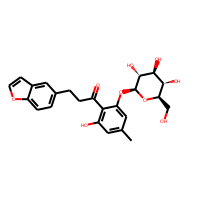
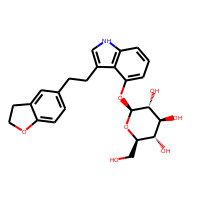

In [550]:
# activity_chembl = pd.DataFrame(activity_chembl, columns=columns)
# activity_chembl['pchembl_value'] = pd.to_numeric(activity_chembl['pchembl_value'])
# PandasTools.AddMoleculeColumnToFrame(activity_chembl, smilesCol = 'canonical_smiles',includeFingerprints=True)
# activity_chembl.to_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/activity_chembl.pkl')
activity_chembl = pd.read_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/activity_chembl.pkl')
print('==========================')
print('%d compounds from ChEMBL'%len(activity_chembl))
print('==========================')
activity_chembl.drop('canonical_smiles',1)[:2]

#### If a compound has multiple pChEMBL, use the average values, and then remove duplicates

In [551]:
# molecule chembl id with duplicates
dp=activity_chembl.duplicated('molecule_chembl_id')
dp_mol=list(set(activity_chembl[dp]['molecule_chembl_id']))

# calculate average pchembal of duplicates
dp_mol_activity = []
for _, x in enumerate(dp_mol):
    avg_pchembl = activity_chembl[activity_chembl['molecule_chembl_id']==x]['pchembl_value'].mean()
    dp_mol_activity.append([x, np.round(avg_pchembl,3)])
dp_mol_activity = np.array(dp_mol_activity)

# remove duplicates and keep the first match
activity_chembl = activity_chembl.drop_duplicates('molecule_chembl_id', keep='first')
activity_chembl = activity_chembl.reset_index(drop=True)

# replace the original pchembl with the averaged pchembl 
idxlist=[]
for i, x in enumerate(dp_mol_activity):
    idx=activity_chembl[activity_chembl['molecule_chembl_id']==x[0]].index[0]
    idxlist.append(idx)
activity_chembl['pchembl_value'].iloc[idxlist] = dp_mol_activity[:,1].astype(float)

print('=============================================================')
print('%d ChEMBL compounds with IC50 activity to SGLT protein'%len(activity_chembl))
print('=============================================================')

1691 ChEMBL compounds with IC50 activity to SGLT protein


/Volumes/750G_Home/anaconda3/envs/my-rdkit-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


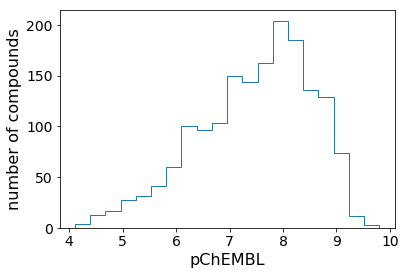

In [552]:
plt.figure()
plt.hist(activity_chembl['pchembl_value'],bins=20, histtype='step', stacked=True, 
         fill=False, )
plt.xlabel('pChEMBL', fontsize=16)
plt.ylabel('number of compounds', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

# Machine Learning - property prediction of the in-house compounds
## QSAR by Random Forest Regression
- Use molecular descriptors and activities available in ChEMBL to construct a regression model

### Calculate Molecular Descriptors of 1691 public compounds (training/test data)

In [566]:
mol_chembl_df = activity_chembl[['molecule_chembl_id','canonical_smiles']].copy()

# remove salts and solvates
smiles = list(map(lambda i: unsalt(i), list(activity_chembl['canonical_smiles'])))
mol_chembl_df['canonical_smiles']=smiles
PandasTools.AddMoleculeColumnToFrame(mol_chembl_df, smilesCol = 'canonical_smiles',includeFingerprints=True)

In [563]:
from rdkit.ML.Descriptors import MoleculeDescriptors

In [564]:
nms=[x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)

In [567]:
nms=[x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)

mol_chembl_mp = []
for i in log_progress(range(len(mol_chembl_df)), every=10):
    sm = mol_chembl_df['canonical_smiles'].iloc[i]
    m = Chem.MolFromSmiles(sm)
    mp = list(calc.CalcDescriptors(m))
    mol_chembl_mp.append(mp)
mol_chembl_mp = pd.DataFrame(mol_chembl_mp, columns=nms)

In [604]:
rows, cols = np.where(np.isnan(mol_chembl_mp))
len(list(set(rows)))

0

In [603]:
mol_chembl_mp.to_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/mol_chembl_mp.pkl')
mol_chembl_mp = pd.read_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/mol_chembl_mp.pkl')
print('%d descriptors calculated'%mol_chembl_mp.shape[1])

115 descriptors calculated


### Random Forest Regression Model

The following section will demonstrate the construction of regression models using Random Forests from scikit-learn. The dataset consists of public compounds with precaclulated descriptors. The data is on the SGLT protein and consists of 1691 compound obtained from ChEMBL.

In [606]:
from sklearn import tree, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold, train_test_split

In [605]:
x = mol_chembl_mp.copy()
#remove properties not required for learning 
x = x.drop('MaxAbsPartialCharge',1)
x = x.drop('MaxPartialCharge',1)
x = x.drop('MinAbsPartialCharge',1)
x = x.drop('MinPartialCharge',1)
x = x.drop('Ipc',1)

#output variables are transferred to a frame called y
y = activity_chembl.pchembl_value

#use the column names as labels for later
Desc_values = list(x.columns)
Desc_values

['HeavyAtomMolWt',
 'qed',
 'MinAbsEStateIndex',
 'NumRadicalElectrons',
 'MaxAbsEStateIndex',
 'MolWt',
 'ExactMolWt',
 'FpDensityMorgan1',
 'NumValenceElectrons',
 'MinEStateIndex',
 'FpDensityMorgan3',
 'MaxEStateIndex',
 'FpDensityMorgan2',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'SlogP_VSA9',
 'TPSA',
 'EState_VSA1',
 'EStat

In [575]:
#set to floating point type
x = x.astype('float32')
y = y.astype('float32')

In [577]:
# Divide the original dataset into training (80%) and test (20%) set
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=23)

In [578]:
custom_forest = ensemble.RandomForestRegressor()
params = {'oob_score':[True],'n_estimators':[250]}

# cv = KFold(n_splits=10, shuffle=True)
# cv_stratified = StratifiedKFold(n_splits=5, shuffle=True)
gs = GridSearchCV(custom_forest, params, cv=10,verbose=1,refit=True)
gs.fit(X_train2,y_train2)
ztest2 = gs.predict(X_test2)
ztest_train2 = gs.predict(X_train2)
best_forest2 = gs.best_estimator_

print( '80% - 20% completed') 
print( 'Best score: %0.2f'%gs.best_score_)
print( 'Training set performance using best parameters (%s)'%gs.best_params_)

print( 'Explained variance (Internal): %0.5f'%(best_forest2.score(X_train2,y_train2)))
print( 'MSE (Internal): %0.5f'%(mean_squared_error(y_train2,ztest_train2)))
print( 'Explained variance (External): %0.5f'%(best_forest2.score(X_test2,y_test2)))
print( 'MSE (External): %0.5f'%(mean_squared_error(y_test2,ztest2)))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


80% - 20% completed
Best score: 0.64
Training set performance using best parameters ({'oob_score': True, 'n_estimators': 250})
Explained variance (Internal): 0.94150
MSE (Internal): 0.06676
Explained variance (External): 0.68381
MSE (External): 0.34139


(4.360000133514404, 9.800000190734863)

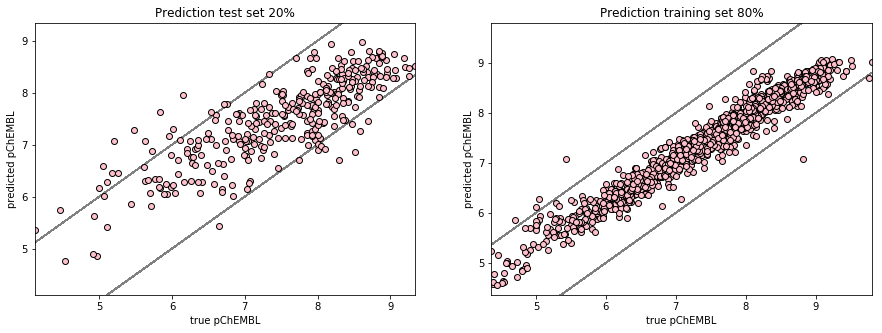

In [608]:
figure,(plt5,plt6) = plt.subplots(1,2)
figure.set_size_inches(15,5)
plt5.plot(x-1,x,c='gray', linewidth=1,zorder=1)
plt5.plot(x+1,x,c='gray', linewidth=1,zorder=1)
plt5.scatter(y_test2,ztest2,c='pink', edgecolors='k',label='test',zorder=2)
minn = np.min(np.concatenate([y_test2,ztest2],axis=0))
maxx = np.max(np.concatenate([y_test2,ztest2],axis=0))
plt5.set_ylim([minn,maxx])
plt5.set_xlim([minn,maxx])
plt5.set_xlabel('true pChEMBL')
plt5.set_ylabel('predicted pChEMBL')
plt5.set_title("Prediction test set 20%")

plt6.plot(x-1,x,c='gray', linewidth=1,zorder=1)
plt6.plot(x+1,x,c='gray', linewidth=1,zorder=1)
plt6.scatter(y_train2,ztest_train2,c='pink',edgecolors='k',label='test',zorder=2)
plt6.set_xlabel('true pChEMBL')
plt6.set_ylabel('predicted pChEMBL')
plt6.set_title("Prediction training set 80%")
minn = np.min(np.concatenate([y_train2,ztest_train2],axis=0))
maxx = np.max(np.concatenate([y_train2,ztest_train2],axis=0))
plt6.set_ylim([minn,maxx])
plt6.set_xlim([minn,maxx])

## Model interpretation

In [613]:
def createImportancePlot(splt,desc,importances,caption):
    #plt.xkcd()
    import numpy as np    
    labels = []
    weights = []
    threshold = np.sort([abs(w) for w in importances])[-9]
    for d in zip(desc,importances):
        if abs(d[1]) > threshold:
            labels.append(d[0])
            weights.append(d[1])
    
    xlocations = np.array(range(len(labels)))+1
    width = 0.8
    splt.bar(xlocations, weights, width=width, color='pink')
    splt.set_xticks([r+1 for r in range(len(labels))])
    splt.set_xticklabels(labels, rotation='vertical', fontsize=12)
    splt.set_xlim(0, xlocations[-1]+width*2)
    splt.set_title(caption)
    splt.get_xaxis().tick_bottom()
    splt.get_yaxis().tick_left()

110


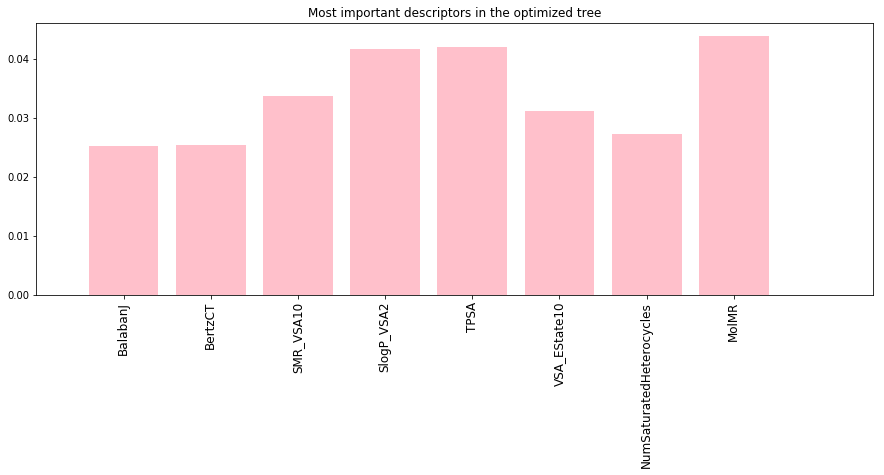

In [614]:
feat_imp = best_forest2.feature_importances_
print( len(feat_imp))
fig,a = plt.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,list(x.columns),feat_imp,"Most important descriptors in the optimized tree")

In [589]:
print( "Cross validated parameters") 
Cross_val_MSE_80 = mean_squared_error(y_train2, ztest_train2)
print( "Cross_val_MSE: ", Cross_val_MSE_80)
Cross_val_Exp_var_80 = explained_variance_score(y_train2, ztest_train2)
print( "Cross_val_Explained_variance: " , Cross_val_Exp_var_80)
Cross_val_R2_80 = r2_score(y_train2, ztest_train2)
print( "Cross_val_R2_score: " , Cross_val_R2_80)
print( "")
print( 'Externally validated parameters')
Ext_val_MSE_80 = extvmetrics2 = mean_squared_error(y_test2 , ztest2)
print( "Ext_val_MSE: ", Ext_val_MSE_80) 
Ext_val_Exp_var_80 =explained_variance_score(y_test2 , ztest2)
print( "Ext_val_Explained_variance: " , Ext_val_Exp_var_80)
Ext_val_R2_80 = r2_score(y_test2 , ztest2)
print( "Ext_val_R2_score: " , Ext_val_R2_80 )

Cross validated parameters
Cross_val_MSE:  0.06676437163720245
Cross_val_Explained_variance:  0.9415110084646285
Cross_val_R2_score:  0.9415035999811509

Externally validated parameters
Ext_val_MSE:  0.3413914135641929
Ext_val_Explained_variance:  0.6838834009189805
Ext_val_R2_score:  0.6838130924933521


In [590]:
Validation2 = pd.DataFrame.from_items([ ('Parameter', ['Mean Squared Error' , 'Explained variance' , 'R2 Score']), ('Cross Validation', [Cross_val_MSE_80, Cross_val_Exp_var_80, Cross_val_R2_80 ]), ('External Validation', [Ext_val_MSE_80, Ext_val_Exp_var_80, Ext_val_R2_80 ]), ('Difference', [Ext_val_MSE_80 - Cross_val_MSE_80, Ext_val_Exp_var_80 - Cross_val_Exp_var_80, Ext_val_R2_80 - Cross_val_R2_80])])
Validation2

/Volumes/750G_Home/anaconda3/envs/my-rdkit-env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Parameter,Cross Validation,External Validation,Difference
0,Mean Squared Error,0.066764,0.341391,0.274627
1,Explained variance,0.941511,0.683883,-0.257628
2,R2 Score,0.941504,0.683813,-0.257691


## Predict pChEMBL of in-house compounds

In [ ]:
data2_prop=[]
for i in log_progress(range(len(data2)), every=10):
    sm = data2['SMILES'].iloc[i]
    m = Chem.MolFromSmiles(sm)
    mp = list(calc.CalcDescriptors(m))
    data2_prop.append(mp)
data2_prop = pd.DataFrame(data2_prop, columns=nms)

### Calculate Molecular Descriptors of 778 in-house compounds

In [615]:
data2_ro5=[]
for i in log_progress(range(len(data2)), every=10):
    sm = data2['SMILES'].iloc[i]
    m = Chem.MolFromSmiles(sm)
    mw = mol_chembl_mp['MolWt'].iloc[i]
    alogp = Descriptors.MolLogP(m)
    tpsa = Descriptors.TPSA(m)
    hba = Descriptors.NumHAcceptors(m)
    hbd = Descriptors.NumHDonors(m)
    ar = Descriptors.NumAromaticRings(m)
    rtb = Descriptors.NumRotatableBonds(m)
    heavy = Lipinski.HeavyAtomCount(m)
    rule = lipinski_ro5_vio(alogp, hba, hbd, mw)
    properties = [mw, alogp, tpsa, hba, hbd, ar, rtb, heavy, rule]
    data2_ro5.append(rule)
data2_ro5 = pd.DataFrame(data2_ro5, columns=[columns[10]])

In [596]:
x_p = data2_prop.drop('MinPartialCharge',1)
x_p = x_p.drop('MinAbsPartialCharge',1)
x_p = x_p.drop('MaxAbsPartialCharge',1)
x_p = x_p.drop('MaxPartialCharge',1)
x_p = x_p.drop('Ipc',1)
rows, cols = np.where(np.isnan(x_p))
print(len(list(set(rows))))
rows, cols = np.where(np.isinf(x_p))
print(len(list(set(rows))))

0
0


In [597]:
x_p = x_p.astype('float32')
pchembl_predict = gs.predict(x_p)
pchembl_predict = pd.DataFrame(pchembl_predict, columns=['pchembl_value'])

### Predicted pChEMBL of 778 in-house compounds

,compound_id,ROMol,pchembl_value,num_lipinski_ro5_violations
0,1,,6.474599,0
1,2,,7.020178,1
2,3,,5.650683,0
3,4,,5.784868,0
4,5,,6.898990,0

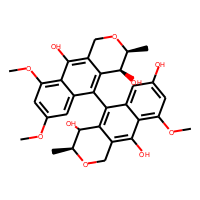
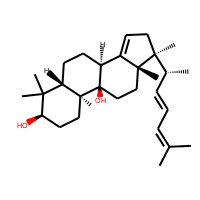
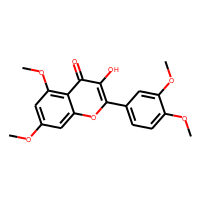
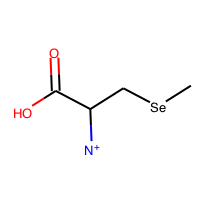
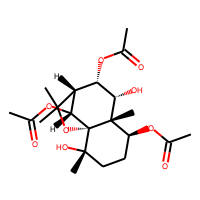

In [617]:
data2_all=pd.concat([data2,data2_prop, pchembl_predict, data2_ro5],axis=1)

sel=['compound_id','ROMol','pchembl_value','num_lipinski_ro5_violations']
data2_all[sel].head()

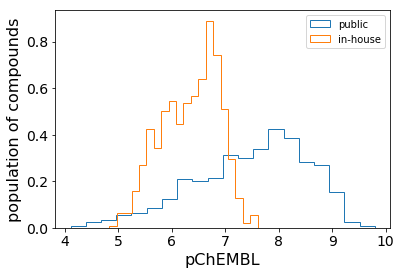

In [618]:
plt.figure()
plt.hist(activity_chembl['pchembl_value'],bins=20, histtype='step', stacked=True, 
         fill=False, label='public', density=True)
plt.hist(pchembl_predict['pchembl_value'],bins=20, histtype='step', stacked=True, 
         fill=False, label='in-house', density=True)
plt.xlabel('pChEMBL', fontsize=16)
plt.ylabel('population of compounds', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend()
plt.show()

### rank in-house compounds by the predicted pChEMBL

,compound_id,ROMol,pchembl_value,num_lipinski_ro5_violations
0,114,,7.608428,1
1,621,,7.592900,1
2,441,,7.555670,0
3,601,,7.524710,0
4,482,,7.508720,1
5,378,,7.478636,2
6,561,,7.427941,0
7,847,,7.340290,2
8,729,,7.329832,0
9,860,,7.320022,1

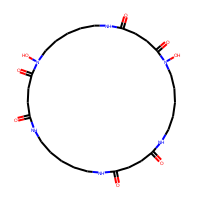
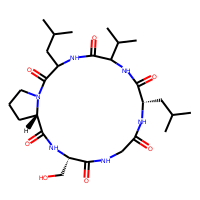
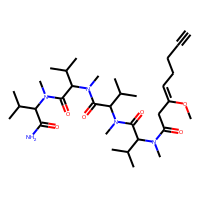
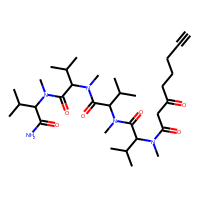
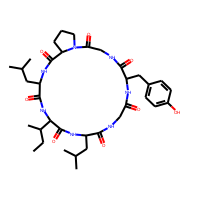
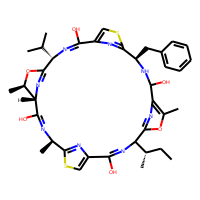
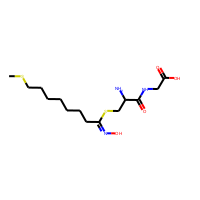
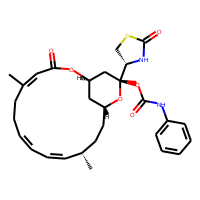
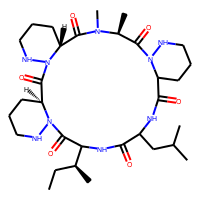
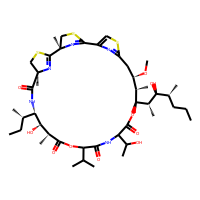

In [619]:
data2_all_sorted = data2_all.sort_values(by=['pchembl_value'], ascending=False).reset_index(drop=True)
data2_all_sorted[sel][:10]

#### compounds satisfying all the Lipinski's rule of 5

,compound_id,ROMol,pchembl_value,num_lipinski_ro5_violations
2,441,,7.555670,0
3,601,,7.524710,0
6,561,,7.427941,0
8,729,,7.329832,0
11,463,,7.297044,0
12,314,,7.295405,0
15,420,,7.249683,0
17,724,,7.233896,0
18,354,,7.231939,0
19,764,,7.208263,0

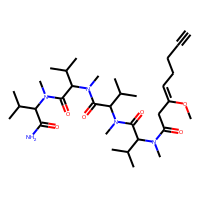
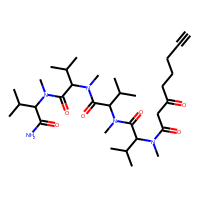
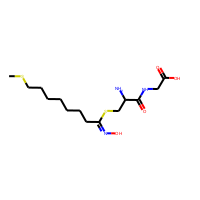
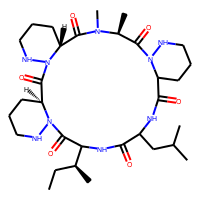
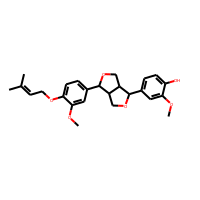
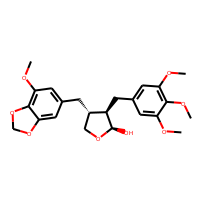
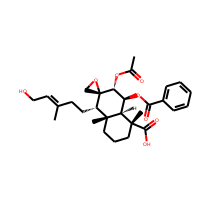
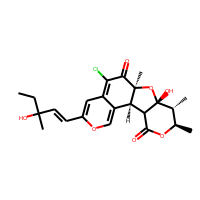
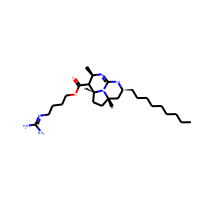
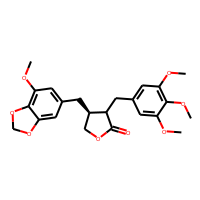

In [620]:
data2_all_sorted = data2_all.sort_values(by=['pchembl_value'], ascending=False).reset_index(drop=True)
data2_all_sorted[sel][data2_all_sorted['num_lipinski_ro5_violations']==0][:10]

#### Most active compounds in the ChEMBL library

,molecule_chembl_id,target_chembl_id,pchembl_value,ROMol
21,CHEMBL485830,CHEMBL4979,9.80,
20,CHEMBL521026,CHEMBL4979,9.77,
1117,CHEMBL1164052,CHEMBL3884,9.52,
1544,CHEMBL3703868,CHEMBL3884,9.51,
1596,CHEMBL3985666,CHEMBL3884,9.44,

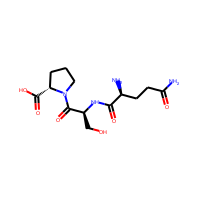
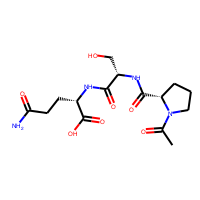
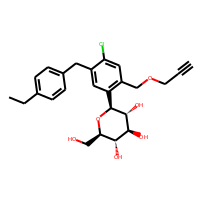
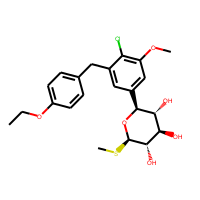
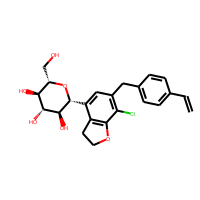

In [622]:
activity_chembl.drop('canonical_smiles',1).sort_values(by='pchembl_value', ascending=False)[:5]

,molecule_chembl_id,target_chembl_id,pchembl_value,ROMol
262,CHEMBL3125314,CHEMBL4979,7.595,
92,CHEMBL496138,CHEMBL4979,7.593,
1187,CHEMBL1672782,CHEMBL3884,7.590,
375,CHEMBL3686413,CHEMBL4979,7.580,
724,CHEMBL3695111,CHEMBL4979,7.580,
1000,CHEMBL567953,CHEMBL3884,7.575,
824,CHEMBL3695209,CHEMBL4979,7.570,
776,CHEMBL3695162,CHEMBL4979,7.570,
424,CHEMBL3686460,CHEMBL4979,7.570,
875,CHEMBL4109996,CHEMBL4979,7.570,

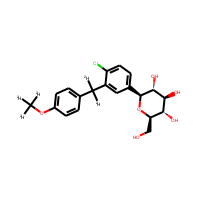
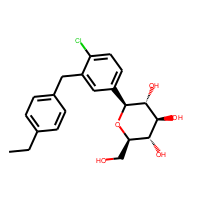
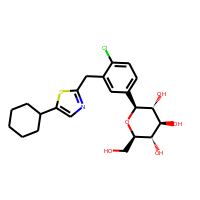
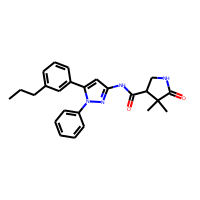
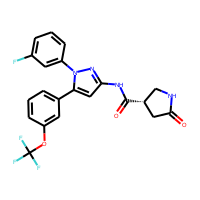
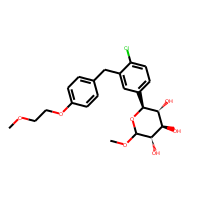
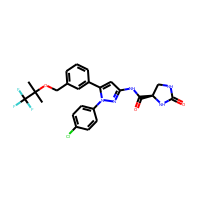
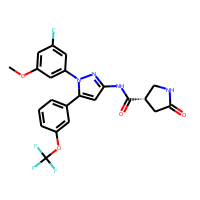
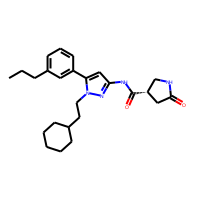
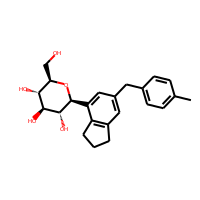
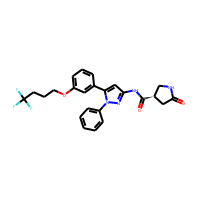
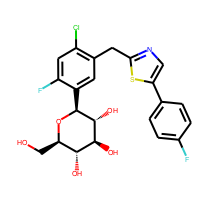
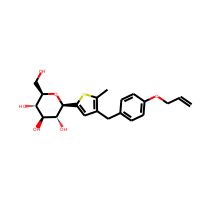
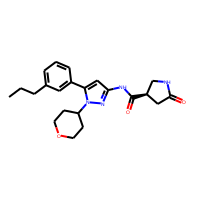
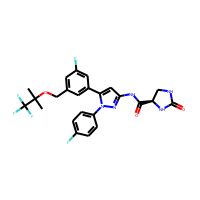
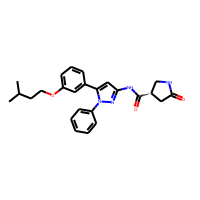
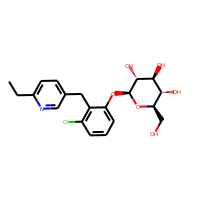
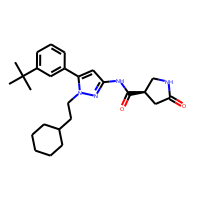
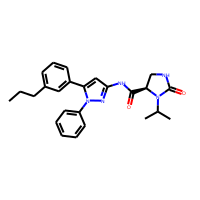
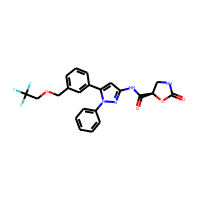
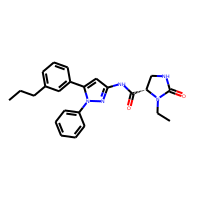
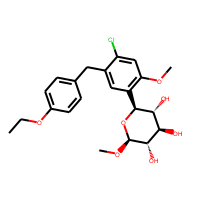
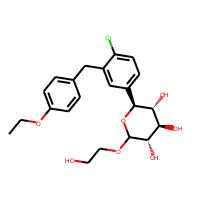
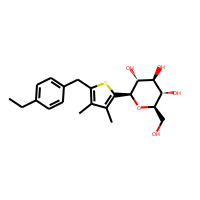
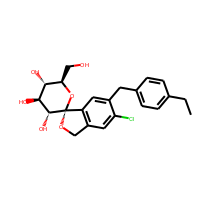
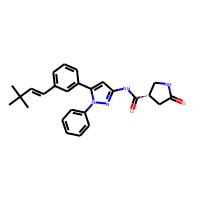
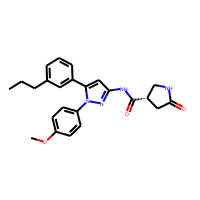
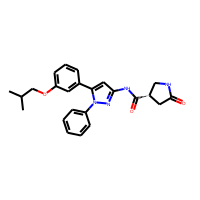
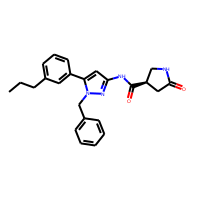
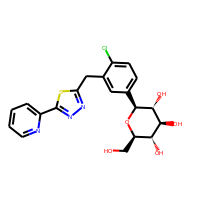
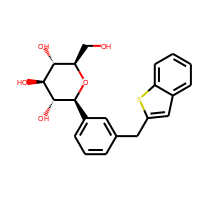
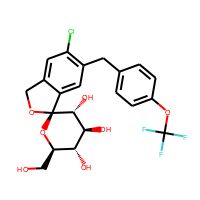
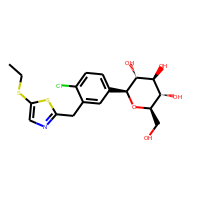
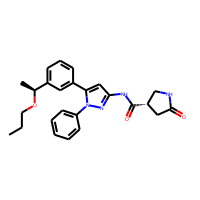
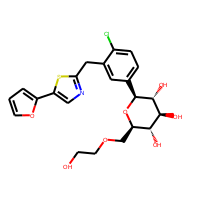
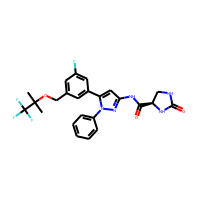
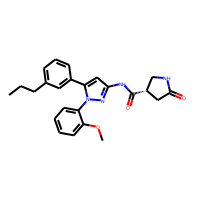
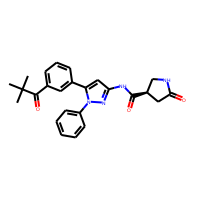
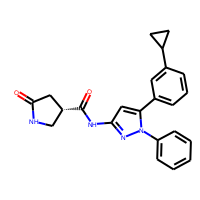
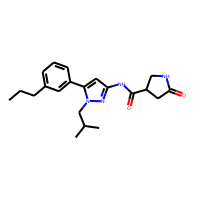
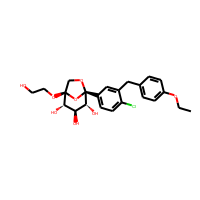

In [625]:
activity_chembl.drop('canonical_smiles',1)[(activity_chembl['pchembl_value']<7.6) & 
 (activity_chembl['pchembl_value']>7.5)].sort_values(by='pchembl_value', ascending=False)

,rank,similarity,product_name,chembl_id,ROMol_drug,compound_id,ROMol_cmp
0,0,0.324324,Dapagliflozin,CHEMBL429910,,300,
1,1,0.307692,Dapagliflozin,CHEMBL429910,,146,
2,2,0.306667,Dapagliflozin,CHEMBL429910,,160,
3,3,0.296296,Glipizide,CHEMBL1073,,312,
4,4,0.296296,Empagliflozin,CHEMBL2107830,,160,
5,5,0.289157,Empagliflozin,CHEMBL2107830,,422,
6,6,0.283784,Dapagliflozin,CHEMBL429910,,722,
7,7,0.282051,Dapagliflozin,CHEMBL429910,,422,
8,8,0.280488,Empagliflozin,CHEMBL2107830,,300,
9,9,0.278481,Empagliflozin,CHEMBL2107830,,940,

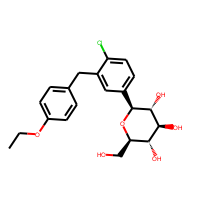
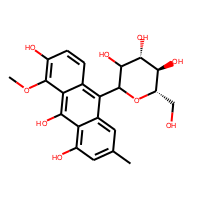
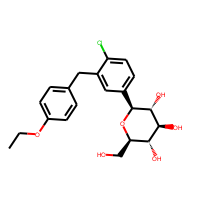
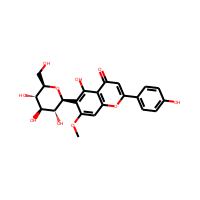
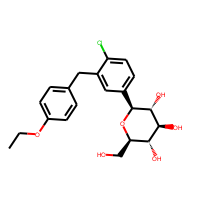
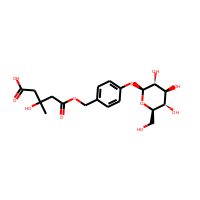
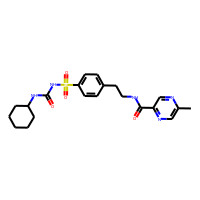
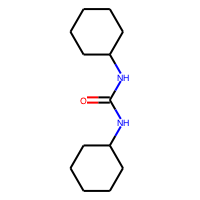
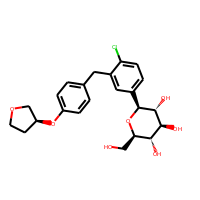
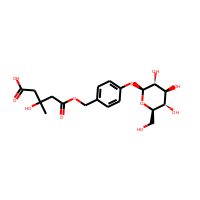
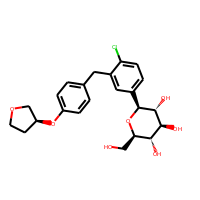
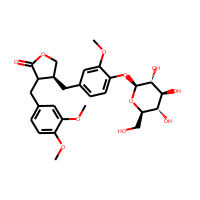
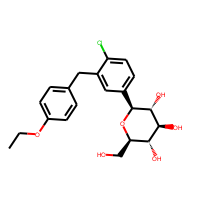
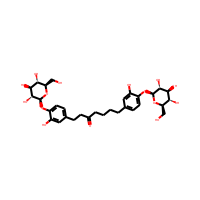
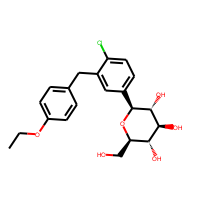
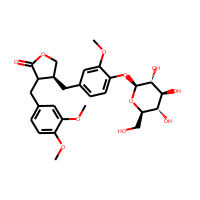
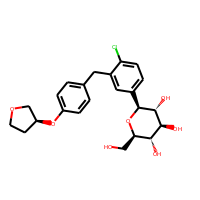
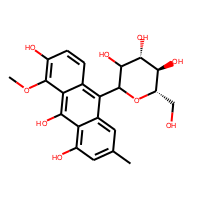
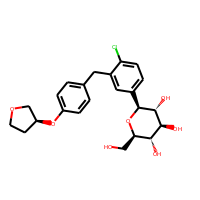
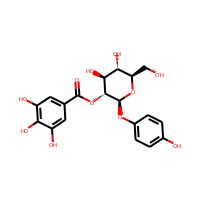

In [276]:
similarity_pairs

# Better approach for similarity search
## visulize chemical space of both in-house and public compounds

### construct fingerprints of public compounds

In [626]:
# chembl compounds
fps_chembl = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mol_chembl_df['ROMol']]
fps_chembl_vec = np.array(fps_chembl)
# in-house compounds
fps_in_house_vec = np.array(fps_in_house)
# approved drugs
fps_drug_vec = np.array(fps_drug)
# all compounds (excluding approved drugs)
fps_all_vec = np.concatenate([fps_chembl_vec, fps_in_house_vec], axis=0)

In [435]:
# save fingerprint bit vectos as matlab matrix
import scipy.io
scipy.io.savemat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/fps_chembl_vec.mat',mdict={'arr': fps_chembl_vec})
scipy.io.savemat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/fps_vec.mat',mdict={'arr': fps_in_house_vec})
scipy.io.savemat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/fps_drug_vec.mat',mdict={'arr': fps_drug_vec})
scipy.io.savemat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/fps_all_vec.mat',mdict={'arr': fps_all_vec})



### t-SNE by Matlab statistics & machine learning toolbox

In [627]:
# Matlab statistics machine learning toolbox
# fps_vec=load('~/Desktop/JOB/BrightSeed/fps_all_vec.mat')
# X = single(fps_vec.arr);
# Y = tsne(X,'Algorithm','exact','Distance','hamming','Perplexity',25,'NumDimensions',2);
# gscatter(Y(:,1),Y(:,2),species)
# save('~/Desktop/JOB/BrightSeed/Y_all_chembl2.mat','Y')

reduced_cmp = scipy.io.loadmat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/Y_all_chembl.mat')
reduced_cmp = reduced_cmp['Y']

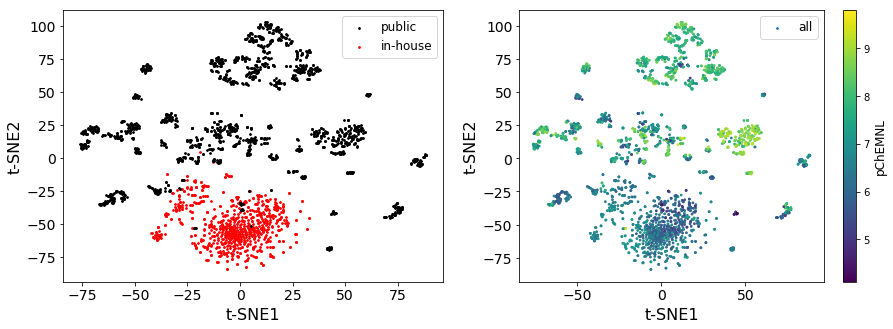

In [628]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(reduced_cmp[:len(fps_chembl),0], reduced_cmp[:len(fps_chembl),1], label='public', c='k',s=3, zorder=5)
plt.scatter(reduced_cmp[len(fps_chembl):,0], reduced_cmp[len(fps_chembl):,1], label='in-house', c='r', s=3, zorder=1)
plt.legend(fontsize=12)
plt.xlabel('t-SNE1', fontsize=16)
plt.ylabel('t-SNE2', fontsize=16)
plt.tick_params(labelsize=14)

pchembl_all = pd.concat([activity_chembl['pchembl_value'],pchembl_predict['pchembl_value']]).reset_index(drop=True)
plt.subplot(1,2,2)
plt.scatter(reduced_cmp[:,0], reduced_cmp[:,1], 
            label='all', c=pchembl_all, s=3, zorder=5)
cbar = plt.colorbar()
cbar.set_label('pChEMNL', fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('t-SNE1', fontsize=16)
plt.ylabel('t-SNE2', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

# Different Targets -- Dipeptidyl peptidase IV

In [631]:
activities = new_client.activity
targetlist2=['CHEMBL284']

mol_activity2 = []
for _, target in enumerate(targetlist2):
    mol_activity2.append(activities.filter(target_chembl_id=target, pchembl_value__isnull=False))

for _, (target, mol) in enumerate(zip(targetlist2, mol_activity2)):
    print("%s molecules with %s" %(len(mol.all()), target))

4482 molecules with CHEMBL284


In [633]:
columns=['molecule_chembl_id','target_chembl_id','canonical_smiles','pchembl_value']
activity_chembl2 = []
for i in range(len(mol_activity2)):
    for j in log_progress(range(len(mol_activity2[i])),every=10):
        mol=mol_activity2[i][j]
        activity_chembl2.append(list(map(lambda k: mol[k], columns)))

In [635]:
activity_chembl2 = pd.DataFrame(activity_chembl2, columns=columns)
activity_chembl2['pchembl_value'] = pd.to_numeric(activity_chembl2['pchembl_value'])
# PandasTools.AddMoleculeColumnToFrame(activity_chembl2, smilesCol = 'canonical_smiles',includeFingerprints=True)
activity_chembl2.to_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/activity_chembl2.pkl')
activity_chembl2 = pd.read_pickle('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/activity_chembl2.pkl')
print('==========================')
print('%d compounds from ChEMBL'%len(activity_chembl2))
print('==========================')
activity_chembl2.drop('canonical_smiles',1)[:2]


4482 compounds from ChEMBL


,molecule_chembl_id,target_chembl_id,pchembl_value
0,CHEMBL443622,CHEMBL284,4.39
1,CHEMBL403882,CHEMBL284,4.82


In [641]:
# molecule chembl id with duplicates
dp=activity_chembl2.duplicated('molecule_chembl_id')
dp_mol=list(set(activity_chembl2[dp]['molecule_chembl_id']))

# calculate average pchembal of duplicates
dp_mol_activity = []
for _, x in enumerate(dp_mol):
    avg_pchembl = activity_chembl2[activity_chembl2['molecule_chembl_id']==x]['pchembl_value'].mean()
    dp_mol_activity.append([x, np.round(avg_pchembl,3)])
dp_mol_activity = np.array(dp_mol_activity)

# remove duplicates and keep the first match
activity_chembl2 = activity_chembl2.drop_duplicates('molecule_chembl_id', keep='first')
activity_chembl2 = activity_chembl2.reset_index(drop=True)

# replace the original pchembl with the averaged pchembl 
idxlist=[]
for i, x in enumerate(dp_mol_activity):
    idx=activity_chembl2[activity_chembl2['molecule_chembl_id']==x[0]].index[0]
    idxlist.append(idx)
activity_chembl2['pchembl_value'].iloc[idxlist] = dp_mol_activity[:,1].astype(float)

print('=============================================================')
print('%d ChEMBL compounds with IC50 activity to SGLT protein'%len(activity_chembl2))
print('=============================================================')

3835 ChEMBL compounds with IC50 activity to SGLT protein


/Volumes/750G_Home/anaconda3/envs/my-rdkit-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [662]:
t[pd.isna(activity_chembl2['canonical_smiles'])]

,0
3356,3356
3615,3615
3616,3616
3617,3617


In [669]:
activity_chembl2=activity_chembl2.drop(3356)
activity_chembl2=activity_chembl2.drop(3615)
activity_chembl2=activity_chembl2.drop(3616)
activity_chembl2=activity_chembl2.drop(3617)
activity_chembl2.shape

(3831, 4)

In [670]:
mol_chembl_df2 = activity_chembl2[['molecule_chembl_id','canonical_smiles']].copy()

# remove salts and solvates
smiles = list(map(lambda i: unsalt(i), list(activity_chembl2['canonical_smiles'])))
mol_chembl_df2['canonical_smiles']=smiles
PandasTools.AddMoleculeColumnToFrame(mol_chembl_df2, smilesCol = 'canonical_smiles',includeFingerprints=True)

In [673]:
# chembl compounds
fps_chembl2 = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mol_chembl_df2['ROMol']]
fps_chembl2_vec = np.array(fps_chembl2)
# in-house compounds
fps_in_house_vec = np.array(fps_in_house)
# approved drugs
fps_drug_vec = np.array(fps_drug)
# all compounds (excluding approved drugs)
fps_all_vec2 = np.concatenate([fps_chembl2_vec, fps_in_house_vec], axis=0)

In [674]:
scipy.io.savemat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/fps_all_vec2.mat',mdict={'arr': fps_all_vec2})


In [676]:
reduced_cmp2 = scipy.io.loadmat('/Volumes/750G_Home/Users/appleowner/Desktop/JOB/BrightSeed/Y_all_chembl2.mat')
reduced_cmp2 = reduced_cmp2['Y']

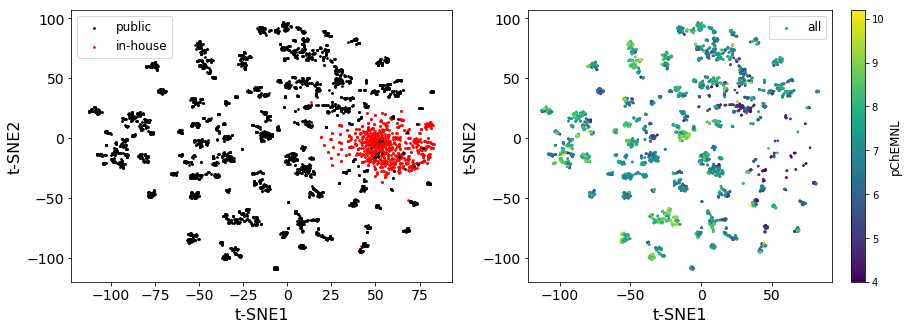

In [679]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(reduced_cmp2[:len(fps_chembl2),0], reduced_cmp2[:len(fps_chembl2),1], label='public', c='k',s=3, zorder=5)
plt.scatter(reduced_cmp2[len(fps_chembl2):,0], reduced_cmp2[len(fps_chembl2):,1], label='in-house', c='r', s=3, zorder=1)
plt.legend(fontsize=12)
plt.xlabel('t-SNE1', fontsize=16)
plt.ylabel('t-SNE2', fontsize=16)
plt.tick_params(labelsize=14)

plt.subplot(1,2,2)
plt.scatter(reduced_cmp2[:len(fps_chembl2):,0], reduced_cmp2[:len(fps_chembl2),1], 
            label='all', c=activity_chembl2['pchembl_value'], s=3, zorder=5)
cbar = plt.colorbar()
cbar.set_label('pChEMNL', fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('t-SNE1', fontsize=16)
plt.ylabel('t-SNE2', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

# Substructure analysis

## Naive Bayes Classification

In [699]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc,accuracy_score

def confusion_matrix_summary(acts,preds):
    from io import StringIO
    file_str = StringIO()
    vTab=confusion_matrix(acts,preds)
    #print vTab
    nResultCodes=len(vTab)
    file_str.write('\n\tResults Table (experiment in rows):\n')
    colCounts = numpy.sum(vTab,0)
    rowCounts = numpy.sum(vTab,1)
    print
    for i in range(nResultCodes):
        if rowCounts[i]==0: rowCounts[i]=1
        row = vTab[i]
        file_str.write('    ')
        for j in range(nResultCodes):
            entry = row[j]
            file_str.write(' % 6d'%entry),
        file_str.write('     | % 4.2f\n'%(100.*vTab[i,i]/rowCounts[i]))
    file_str.write('    ')
    for i in range(nResultCodes):
        file_str.write('-------')
    file_str.write('\n')
    file_str.write('    '),
    for i in range(nResultCodes):
        if colCounts[i]==0: colCounts[i]=1
        file_str.write(' % 6.2f'%(100.*vTab[i,i]/colCounts[i])),
    file_str.write('\n')
    return file_str.getvalue()

def createROCPlot(pl,observations,probabilities,caption):
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('False Positive Rate')
    pl.set_ylabel('True Positive Rate')
    pl.set_title(caption)
    
def createPropAccPlot(pl,observations,probabilities,caption):
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    accuracies = []
    for t in thresholds:
        
        predictions = [1 if p >= t else 0 for p in probabilities]
        acc = accuracy_score(observations,predictions)
        accuracies.append(acc)
    pl.plot(thresholds, accuracies, label='Prob. vs Accuracy curve')
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('Probability threshold')
    pl.set_ylabel('Accuracy')
    pl.set_title(caption)

def createImportancePlot(splt,desc,importances,caption):
    #plt.xkcd()
    import numpy as np    
    labels = []
    weights = []
    threshold = sort([abs(w) for w in importances])[-11]
    for d in zip(desc,importances):
        if abs(d[1]) > threshold:
            labels.append(d[0])
            weights.append(d[1])
    
    xlocations = np.array(range(len(labels)))+1
    width = 0.8
    splt.bar(xlocations, weights, width=width)
    splt.set_xticks([r+1 for r in range(len(labels))])
    splt.set_xticklabels(labels, rotation='vertical')
    splt.set_xlim(0, xlocations[-1]+width*2)
    splt.set_title(caption)
    splt.get_xaxis().tick_bottom()
    splt.get_yaxis().tick_left()

In [687]:
fps_chembl = []
info_chembl=[]
for _, m in enumerate(mol_chembl_df['ROMol']):
    info = {}
    temp=Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048,bitInfo=info)
    fps_chembl.append(temp)
    info_chembl.append(info)

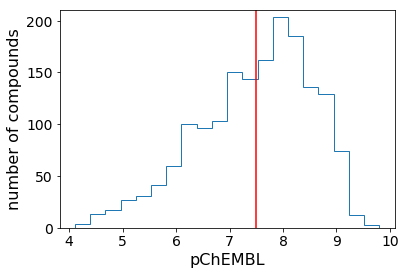

In [838]:
plt.figure()
plt.hist(activity_chembl['pchembl_value'],bins=20, histtype='step', stacked=True, 
         fill=False, )
plt.plot([7.5,7.5],[0,210], color='r')
plt.xlabel('pChEMBL', fontsize=16)
plt.ylabel('number of compounds', fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim([0,210])
plt.show()

In [694]:
class_chembl=[1 if m > 7.5 else 0 for m in activity_chembl['pchembl_value']]

In [721]:
indices = list(range(len(class_chembl)))

In [723]:
x_train, x_test, info_train, info_test, y_train, y_test, indices_train, indices_test = \
train_test_split(fps_chembl, info_chembl, class_chembl, indices, test_size=0.2,  shuffle=True)

In [724]:
from sklearn.naive_bayes import BernoulliNB
morgan_bnb = BernoulliNB(fit_prior=False)
morgan_bnb.fit(x_train,y_train)
morgan_predictions = morgan_bnb.predict(x_test)
print('Morgan Fingerprints')
print( confusion_matrix_summary(y_test,morgan_predictions))
print( classification_report(y_test,morgan_predictions))

morgan_probabilities = [p[1] for p in morgan_bnb.predict_proba(x_test)]

Morgan Fingerprints

	Results Table (experiment in rows):
        123     32     |  79.35
         41    143     |  77.72
    --------------
      75.00  81.71

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       155
           1       0.82      0.78      0.80       184

   micro avg       0.78      0.78      0.78       339
   macro avg       0.78      0.79      0.78       339
weighted avg       0.79      0.78      0.78       339



Area under the ROC curve : 0.824912


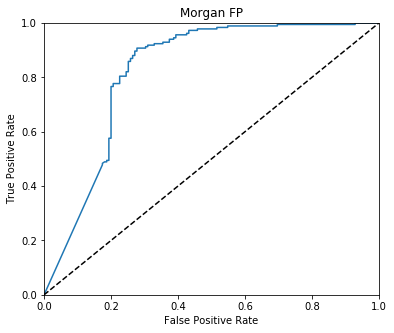

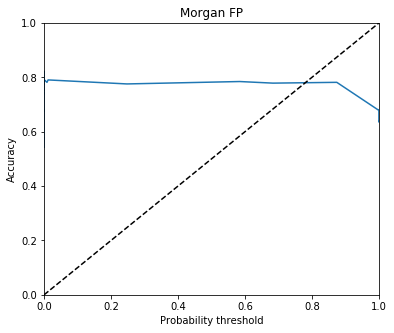

In [725]:
figure,plt1 = pyplot.subplots(1,1)
figure.set_size_inches(6,5)
# figure.tight_layout()

createROCPlot(plt1,y_test,morgan_probabilities,'Morgan FP')

figure,plt1 = pyplot.subplots(1,1)
figure.set_size_inches(6,5)
# figure.tight_layout()

createPropAccPlot(plt1,y_test,morgan_probabilities,'Morgan FP')

#### Obtain bit probabilities for later analysis

In [726]:
bit_probabilities = morgan_bnb.feature_log_prob_
position = []
enrichment = []
for d in zip(range(len(bit_probabilities[1])),[(w[0]-w[1]) for w in zip(bit_probabilities[0],bit_probabilities[1])]):
    if abs(d[1]) >= 1: #one log-level probablity difference between classes
        position.append(d[0])
        enrichment.append(d[1])

####  Compute the probability of a bit for each class, identify bits enriched in one class and report substructures associated with these bits. Then identify substructures that occur predominantly in molecules belonging to one class

In [777]:
images = []
smiles = {}
#find all substructures associated with enriched bits
for bit in zip(position,enrichment):
    i = 0
    class0_prob = bit_probabilities[0][bit[0]]
    class1_prob = bit_probabilities[1][bit[0]]
    for info in info_train:
#         if info.has_key(bit[0]):
        if bit[0] in info:
            try:
#                 m = data[train[i]][0]
                m = Chem.MolFromSmiles(activity_chembl['canonical_smiles'].iloc[indices_train[i]])
                atomId,radius = info[bit[0]][0]
                env=Chem.FindAtomEnvironmentOfRadiusN(m,radius,atomId)
                amap={}            
                #submol = Chem.PathToSubmol(m,env,atomMap=amap)
                ats = set([atomId])
                for bidx in env:
                    bond = m.GetBondWithIdx(bidx)
                    ats.add(bond.GetBeginAtomIdx())
                    ats.add(bond.GetEndAtomIdx())
                smi = Chem.MolFragmentToSmiles(m,atomsToUse=list(ats),bondsToUse=env,rootedAtAtom=atomId)
                #smi = Chem.FastFindRings(smi)
                
#                 if smiles.has_key(smi):
                if smi in smiles:
                    num_molecules = smiles[smi][0]
                    num_positives = smiles[smi][1]
                    if class_chembl[indices_train[i]] == 1: num_positives+=1
                    smiles[smi] = (num_molecules+1,num_positives,bit[0],class0_prob,class1_prob)
                else:
                    num_positives = 0
                    if class_chembl[indices_train[i]] == 1: num_positives=1
                    smiles[smi] = (1,num_positives,bit[0],class0_prob,class1_prob)
                
            except:
                continue
        i+=1

        results=[]
for smi in smiles.keys():
    ratio = float(smiles[smi][1])/smiles[smi][0]
    if smiles[smi][0] > 5 and (ratio < 0.2 or ratio > 0.8): #show only substructures occuring in at least 5 molecules, with either less than 20% or more than 80% active proportion
        results.append((smiles[smi][2],smiles[smi][0],smiles[smi][1],(smiles[smi][3]),(smiles[smi][4]),smi))
results.sort(key=lambda x: x[0])
for line in results:        
    print( 'bit %i: \t%i (%i) molecules, in-class log_probabilities %0.3f %0.3f \t SMILES: %s'%line)
    

bit 181: 	8 (0) molecules, in-class log_probabilities -4.025 -6.607 	 SMILES: [C@H](CC)(Oc)[C@@H](C)O
bit 185: 	12 (10) molecules, in-class log_probabilities -5.325 -4.209 	 SMILES: C(C)(C)(OC)C(F)(F)F
bit 193: 	6 (6) molecules, in-class log_probabilities -4.814 -3.239 	 SMILES: [C@H](O)([C@@H](C)O)[C@H](O)S
bit 364: 	16 (0) molecules, in-class log_probabilities -3.590 -6.607 	 SMILES: c([nH]c)c(c)C
bit 403: 	22 (21) molecules, in-class log_probabilities -5.037 -3.388 	 SMILES: [C@@H](C)(O)S
bit 411: 	17 (14) molecules, in-class log_probabilities -4.477 -3.274 	 SMILES: [C@@H](CN)(C(N)=O)[C@H](C)C
bit 555: 	20 (17) molecules, in-class log_probabilities -5.037 -3.471 	 SMILES: C(C)(C)Oc
bit 573: 	21 (20) molecules, in-class log_probabilities -4.814 -3.311 	 SMILES: S(C)[C@H](C)O
bit 635: 	9 (0) molecules, in-class log_probabilities -4.025 -6.607 	 SMILES: n(CC)(c(C)n)c(n)S
bit 710: 	6 (0) molecules, in-class log_probabilities -4.226 -6.607 	 SMILES: c(cc)(-c(c)c)c(C)c
bit 714: 	7 (0) mo

In [778]:
df = pd.DataFrame(results)

In [804]:
substructure_rank = np.flipud(np.argsort(df[4]-df[3]))

In [814]:
fmols=[Chem.MolFromSmiles(s, sanitize=False) for s in df.iloc[substructure_rank[:10]][5]]

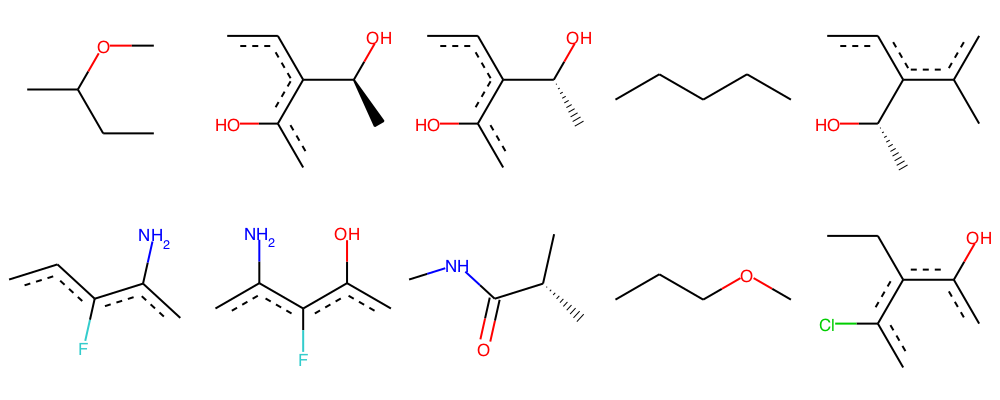

In [825]:
Draw.MolsToGridImage(fmols, molsPerRow=5)

,molecule_chembl_id,target_chembl_id,pchembl_value,ROMol
21,CHEMBL485830,CHEMBL4979,9.80,
20,CHEMBL521026,CHEMBL4979,9.77,
1117,CHEMBL1164052,CHEMBL3884,9.52,
1544,CHEMBL3703868,CHEMBL3884,9.51,
1596,CHEMBL3985666,CHEMBL3884,9.44,

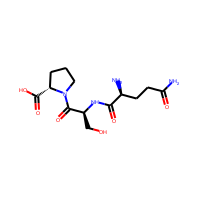
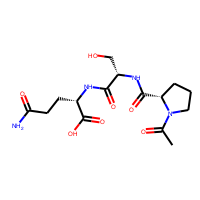
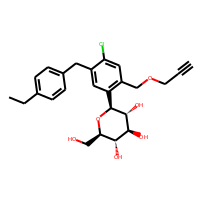
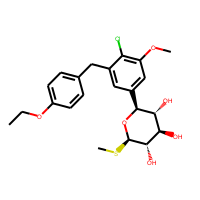
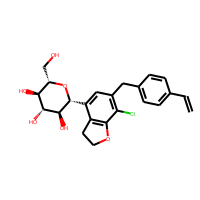

In [839]:
activity_chembl.drop('canonical_smiles',1).sort_values(by='pchembl_value', ascending=False)[:5]